## Load in datasets

The datasets consist of:

    - train.csv (a training dataset)
    - test.csv (a test dataset)
    - oil.csv, transactions.csv, holidays_events.csv (exogenous datasets)
    - stores.csv (a dataset the links store information)

The data is attached in the `data` folder in the `store-sales-time-series-forecasting.zip`, and can be unzipped using the `unzip` command.

In [1]:
import sys

if "../" not in sys.path:
    sys.path.append("../")

from time_series_dataset import SalesDataset


sdata = SalesDataset(
    train_path="../../../data/train.csv", 
    test_path="../../../data/test.csv", 
    oil_path="../../../data/oil.csv"
)

train_loader, val_loader = sdata.get_loaders(include_exog=True)


/Users/cullenpaulisick/opt/anaconda3/envs/default_ml_dev/lib/python3.10/site-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [5]:
# import pandas as pd
# import numpy as np
# from torch.utils.data import DataLoader
# from sklearn.model_selection import train_test_split

# train_df = pd.read_csv("../../../data/train.csv")
# test_df = pd.read_csv("../../../data/test.csv")
# oil_df = pd.read_csv("../../../data/oil.csv")

# # create sample dataset for training
# # merge and reset index
# train_df = train_df.merge(oil_df, on='date', how='left').dropna().set_index("id").reset_index()

# # loader = DataLoader(list(zip(X,y)), shuffle=True, batch_size=16)
# def sales_by_store(data, family: str="AUTOMOTIVE", col_include = ['date', 'sales']):
#     store_data = {}
#     for store in data.store_nbr.unique():
#         train_df = data.loc[data.family==family.upper()]
#         store_data[store] = train_df.loc[train_df.store_nbr==store][col_include].sort_values(by="date", ascending=True).set_index("date")
#         # create target by shifting data forward one period
#         store_data[store]['sales_shift'] = store_data[store].sales.shift(-1)
#         # drop remaining null position at last period
#         store_data[store] = store_data[store].rolling(5).mean()
#         store_data[store].dropna(inplace=True)
#     return store_data

# def groups_of_size(arr: np.array, n: int=20):

#     chunk_indices = list(range(0, arr.size, n))
#     # remove first element to prevent 0-sized first element
#     chunk_indices.pop(0)
#     splits = np.split(arr, chunk_indices)
#     # remove last element if size is non-matching
#     if splits[-1].size != n:
#         splits = np.delete(splits, -1, 0)
    
#     return np.vstack(splits) 

# # get data for each store within sales family
# store_data = sales_by_store(train_df, col_include=['date', 'sales', 'dcoilwtico'])
# # for each store, append to create whole dataset

# sales = np.vstack([groups_of_size(df.sales.values, n=20) for df in store_data.values()])
# sales_shift = np.vstack([groups_of_size(df.sales_shift.values, n=20) for df in store_data.values()])
# oil = np.vstack([groups_of_size(df.dcoilwtico.values, n=20) for df in store_data.values()])



/Users/cullenpaulisick/opt/anaconda3/envs/default_ml_dev/lib/python3.10/site-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [4]:
# from torch.utils.data import DataLoader

# # use just sales as 1-d data (endogenous)
# # use depth stack of sales and oil for exogenous inclusion

# # X = sales
# X = np.dstack([sales, oil])

# if len(X.shape) < 3:
#     X = np.expand_dims(X, axis=2)
# X_train, X_test, y_train, y_test = train_test_split(X, sales_shift, test_size=0.33, random_state=42, shuffle=False)

# input_size = X.shape[-1]
# train_loader = DataLoader(list(zip(X_train,y_train)), shuffle=False, batch_size=16, drop_last=True) 
# val_loader = DataLoader(list(zip(X_test,y_test)), shuffle=False, batch_size=16, drop_last=True) 


## Demonstrate Forward Pass

In [3]:
import torch
from torch import nn

class RNN(nn.Module):
    def __init__(
            self, 
            input_size, 
            output_size,
            hidden_dim, 
            n_layers, 
            drop_prob: float=0.5
        ):
        super(RNN, self).__init__()
        self = self.float()
        # hidden dimension
        self.hidden_dim=hidden_dim
        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        seq_length = x.size(1)
        
        # get output and hidden output for x input and previous hidden dimension
        r_out, hidden = self.rnn(x, hidden)
        out = self.dropout(r_out)
        # shape output to be (batch_size, seq_length, hidden_dim)
        out = out.view(batch_size, seq_length, self.hidden_dim)  
        # get final output 
        output = self.fc(r_out)
        
        return output, hidden

    def training_cycle(self, train_loader, val_loader, epochs, print_every, criterion, optimizer):
        # initialize the hidden state 
        for epoch in range(epochs):
            hidden=None
            # defining the training data 
            running_train_loss = 0
            self.train()
            for x, y in train_loader:
                # set training mode
                # convert data into Tensors
                x_tensor = torch.Tensor(x).float()
                y_tensor = torch.Tensor(y).unsqueeze(-1).float()
                # outputs from the rnn from train
                prediction, hidden = self(x_tensor, hidden)

                ## Representing Memory ##
                # make a new variable for hidden and detach the hidden state from its history
                # this way, we don't backpropagate through the entire history
                hidden = hidden.data
                # calculate the loss
                loss = criterion(prediction, y_tensor)
                # zero gradients
                optimizer.zero_grad()
                # perform backprop and update weights
                loss.backward()
                optimizer.step()
                running_train_loss += loss.item()
            

            # display loss and predictions
            if (epoch % print_every == 0) or (epoch==(epochs-1)): 
                # calculate final_train_loss
                train_loss = running_train_loss/len(train_loader)
                # set to eval mode and run validation
                self.eval()
                hidden=None
                running_val_loss = 0
                for x_test, y_test in val_loader:
                    x_tensor_test = torch.Tensor(x_test).float()
                    y_tensor_test = torch.Tensor(y_test).unsqueeze(-1).float()
                    # outputs from the rnn for validation
                    test_prediction, hidden = self(x_tensor_test, hidden)
                    ## Representing Memory ##
                    # make a new variable for hidden and detach the hidden state from its history
                    # this way, we don't backpropagate through the entire history
                    hidden = hidden.data
                    # calculate the loss
                    val_loss = criterion(test_prediction, y_tensor_test)
                    running_val_loss += val_loss
                self.train()

                val_loss = running_val_loss/len(val_loader)
                print("Epoch: %d, train loss: %1.5f, val loss: %1.5f" % (epoch, train_loss, val_loss))


# declare number of feature variables
input_size = 2
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
# test that dimensions are as expected
train_loader_i = iter(train_loader)
# retrieve sample data to learn from 
x, y = next(train_loader_i)

test_input = torch.Tensor(x).float()
print('Input size: ', test_input.size())
test_rnn = RNN(input_size=input_size, output_size=1, hidden_dim=10, n_layers=2)
test_rnn = test_rnn.float()
# # test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Input size:  torch.Size([16, 20, 2])
Output size:  torch.Size([16, 20, 1])
Hidden state size:  torch.Size([2, 16, 10])


In [4]:
# decide on hyperparameters
input_size=2
output_size=1
hidden_dim=68
n_layers=3



# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
rnn = rnn.float()
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.002) 

rnn.training_cycle(
    train_loader=train_loader, 
    val_loader=val_loader, 
    epochs=300, 
    print_every=20, 
    criterion=criterion, 
    optimizer=optimizer
)


# decide on hyperparameters
hparams = dict(
input_size=2,
output_size=1,
hidden_dim=68,
n_layers=3,
lr = 0.0025
)


with SummaryWriter() as w:
    # instantiate an LSTM with regularization
    lstm = RNN(hparams['input_size'], 
                hparams['output_size'], 
                hparams['hidden_dim'],
                hparams['n_layers'], 
                drop_prob=hparams['drop_prob'])
    # MSE loss and Adam optimizer with a learning rate of 0.01
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=hparams['lr']) 
    
    train_loss, val_loss = lstm.training_cycle(
        batch_size=batch_size,
        train_loader=train_loader, 
        val_loader=val_loader, 
        epochs=300, 
        print_every=30, 
        criterion=criterion, 
        optimizer=optimizer,
        writer=w
    )
    w.add_hparams(hparam_dict=hparams, 
                  metric_dict={
                        "hparam/train_loss":train_loss,
                        "hparam/val_loss":val_loss
                    }
                )
    w.close()


    

Epoch: 0, train loss: 7.94407, val loss: 37.21972
Epoch: 20, train loss: 7.60128, val loss: 37.18589
Epoch: 40, train loss: 7.60096, val loss: 37.19339
Epoch: 60, train loss: 7.60010, val loss: 37.17183
Epoch: 80, train loss: 9.41961, val loss: 41.07083
Epoch: 100, train loss: 7.61395, val loss: 37.19500
Epoch: 120, train loss: 4.21957, val loss: 24.40927
Epoch: 140, train loss: 1.28666, val loss: 7.70897
Epoch: 160, train loss: 1.37846, val loss: 5.20464
Epoch: 180, train loss: 1.51171, val loss: 7.92470
Epoch: 200, train loss: 1.32554, val loss: 4.97803
Epoch: 220, train loss: 1.29583, val loss: 5.30316
Epoch: 240, train loss: 1.39273, val loss: 5.06776
Epoch: 260, train loss: 1.30050, val loss: 4.13921
Epoch: 280, train loss: 1.25995, val loss: 4.71087
Epoch: 299, train loss: 1.33371, val loss: 4.36348


In [6]:
val_loader_i = iter(val_loader)

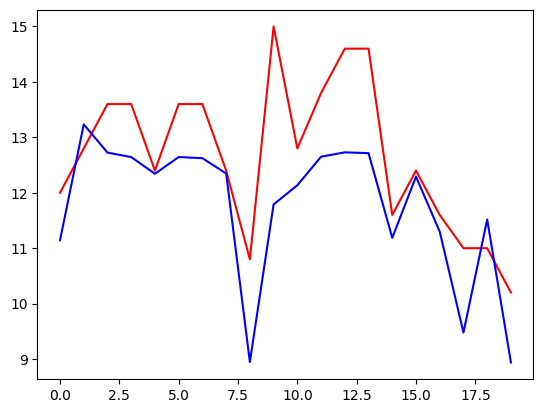

In [27]:
import matplotlib.pyplot as plt 
# sample inference
rnn.eval()
time_steps = range(20)

val_x, val_y = next(val_loader_i)
x_tensor_val = torch.Tensor(val_x[0, :, :]).unsqueeze(0).float()
y_tensor_val = torch.Tensor(val_y[0, :, :]).unsqueeze(0).float()
# y_tensor_val = torch.Tensor(val_y).unsqueeze(-1).float()
hidden = None
prediction, hidden = rnn(x_tensor_val, hidden)

plt.plot(time_steps, x_tensor_val.data.numpy()[:, :, 0].flatten(), 'r-') # input
plt.plot(time_steps, prediction.data.numpy().flatten(), 'b-') # predictions
plt.show()

In [9]:
val_x.shape

torch.Size([16, 20, 2])

In [12]:
x_tensor_val.shape

torch.Size([1, 20, 2])

In [17]:
torch.Tensor(val_y[0, :]).unsqueeze(0).float().numpy().flatten()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)